<a href="https://colab.research.google.com/github/StetskoSergey/pida5_stetsko/blob/master/timeSeries/aml6%20%D0%B2%D1%82%D0%BE%D1%80%D0%B0%D1%8F%20%D1%87%D0%B0%D1%81%D1%82%D1%8C%20dz%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Взять из прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np

In [0]:
sales_of_company_x = pd.read_csv("/content/drive/My Drive/nnn/Series/monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("/content/drive/My Drive/nnn/Series/monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("/content/drive/My Drive/nnn/Series/international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("/content/drive/My Drive/nnn/Series/mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("/content/drive/My Drive/nnn/Series/weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("/content/drive/My Drive/nnn/Series/daily-total-female-births-in-cal.csv")

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"],
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
    "Daily total female births in California": female_births["Count"]
}

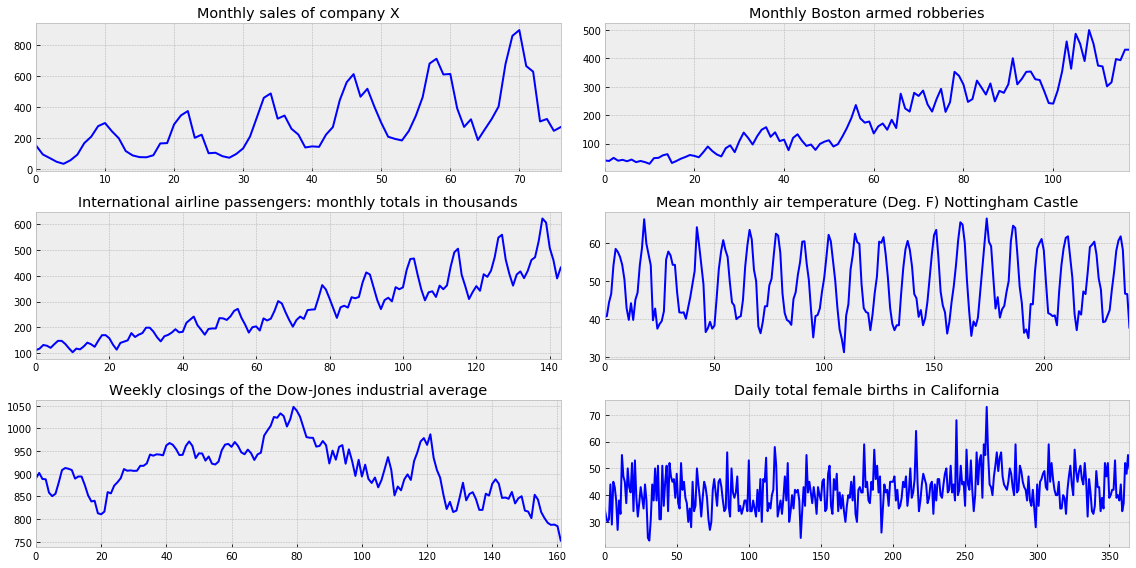

In [10]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

female_births["Count"] возьмем как статичный ряд
приблизим его скользящим средним, взвешенным скользящим средним, экспоненциальным средним

In [0]:
# напишем блоки функций moving_average, weighted_moving_average, exponential_moving_average, triple_exponential_smoothing 
# универсальную кросс валидацию по MSE
# универсальный вывод графика с прогнозированием на preds шагов ...
# Универсальную функцию подбора параметров и вывода предсказаний, вывода mse

from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

def moving_average(series, X, n_preds = 5):
    n, weights, gamma = X
    N = int(n)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    new_series = series.rolling(N).mean()
    for _ in range(n_preds):
      new_series = new_series.append(pd.Series(new_series.rolling(N).mean()[-1:].values[-1]), ignore_index = True)
    return new_series

def weighted_moving_average(series, X, n_preds=5):

    n, weights, gamma = X
    N = int(n)
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(N).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    new_series = pd.Series([np.NaN]).append(wma, ignore_index=True)

    for _ in range(n_preds):
      pred = new_series.rolling(N).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)[-1:1].values[-1]
      new_series = new_series.append(pd.Series(pred, ignore_index = True))
    

def exponential_moving_average(series, X, n_preds=5):
   
    alpha, beta, gamma = X
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    for n in range(len(series), len(series) +n_preds):
        result.append(alpha * result[n-1] + (1 - alpha) * result[n-2])    
    return pd.Series(result) 

def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

def initial_seasonal_components(train, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(train)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(train[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += train[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

def triple_exponential_smoothing(train, X, n_preds=5, slen = 12):
    
    alpha, beta, gamma = X
    result = []
    seasonals = initial_seasonal_components(train, slen)
    
    for i in range(len(train)+n_preds):
        if i == 0: # initial values
            smooth = train[0]
            trend = initial_trend(train, slen)
            result.append(series[0])
            continue
        if i >= len(train): # we are forecasting
            m = i - len(train) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

def mse(train, func, X, preds = 5):
    result = func(train[:(len(train)-preds)], X, preds)
    predictions = result[-preds:]
    error = mean_squared_error(predictions, train[-preds:])
    return error

def mse_cross_val(X, func, train):
    

    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        result = func(train_split, X, len(test_split))
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, test_split)
        errors.append(error)

    return np.mean(np.array(errors))

def plot_tripple(X, series, n_preds=24):
    tema = triple_exponential_smoothing(series, X, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.plot(series, color='blue',label='original')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()                       

def func_plot(func, series, preds, X):
  with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(func(series, X, preds), color='red', linewidth='4', label=func.__name__)
    plt.plot(series, color='blue',label='original')
    plt.legend()

def Opt_param( func, series, X, bounds = ((0, 1), (0, 1), (0, 1)), preds = 5):
  opt = minimize(mse_cross_val, x0=X, args = (func, series), method="L-BFGS-B", bounds = bounds)
  print('параметры ',opt.x)
  func_plot(func, series, preds, opt.x)
  print('mse :', mse(series, func, opt.x, preds))        

In [0]:
series = female_births["Count"]

In [0]:
func_plot(moving_average, series, 7, [])
func_plot(weighted_moving_average, series, 6, [1,2,3,4,5,6])
func_plot(exponential_moving_average, series, 0.2, [])

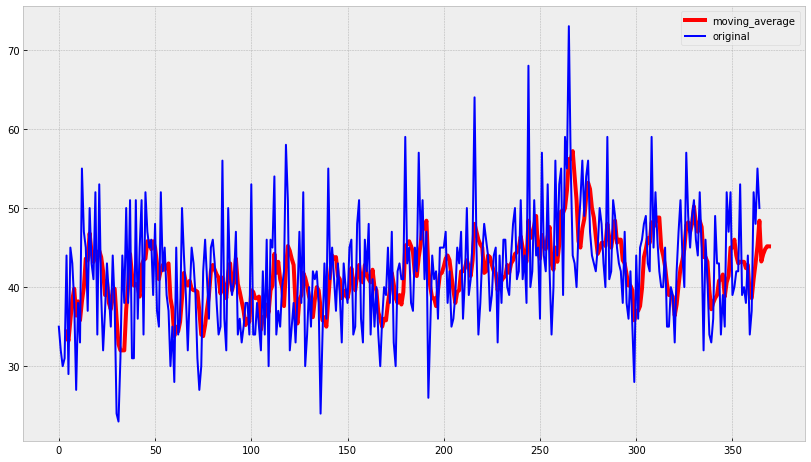

In [87]:
func_plot(moving_average, series, [5,0,0])

параметры  [0.5 0.  0. ]
mse : 123.34272066389387


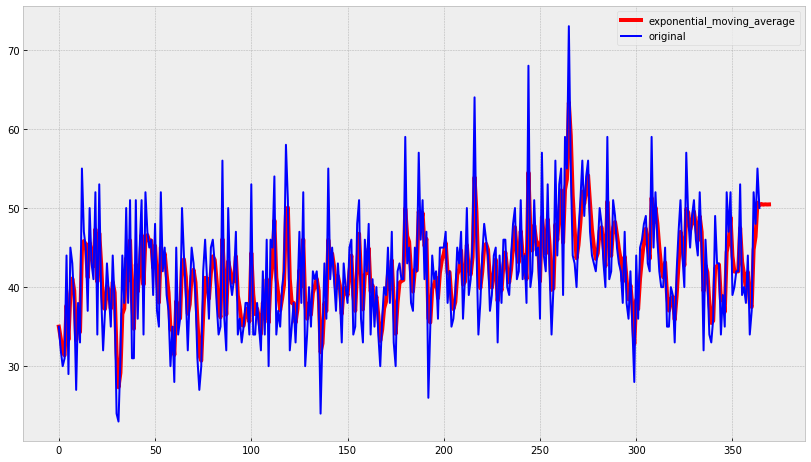

In [150]:
Opt_param(exponential_moving_average,series,[0,0,0], ((0, 0.5), (0, 1), (0, 1)))


параметры  [5. 0. 0.]
mse : 85.56390956155104


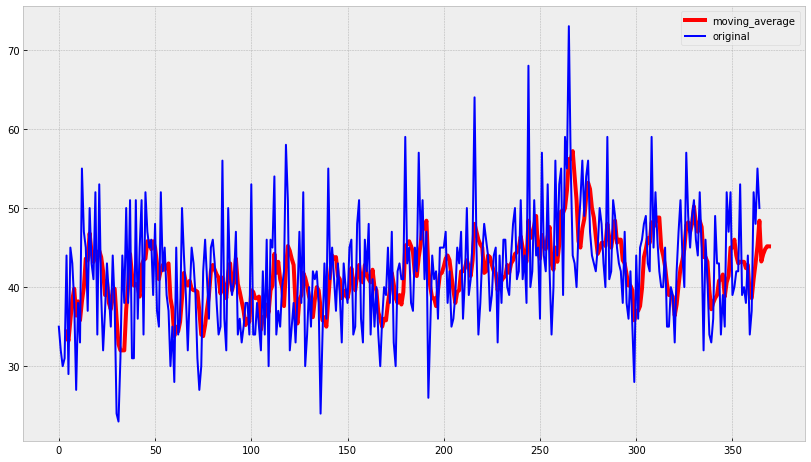

In [151]:
Opt_param(moving_average,series,[0,0,0], ((5, 10), (0, 1), (0, 1)))



параметры  [0.6019041  0.00614792 1.        ]
mse : 257.20030202559576


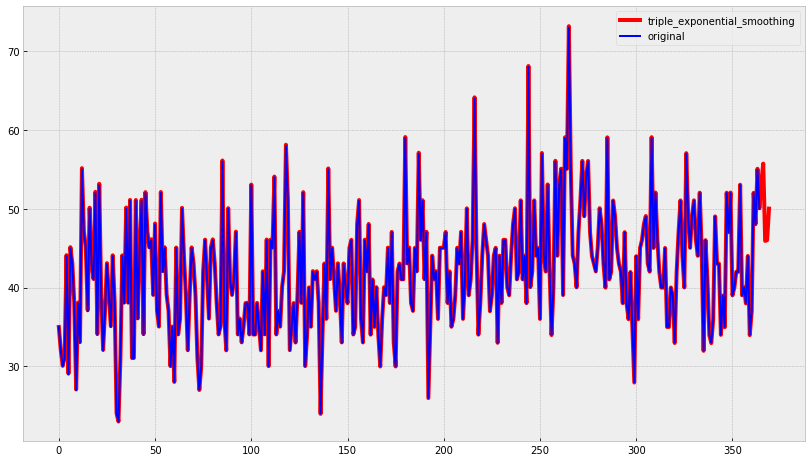

In [152]:
Opt_param(triple_exponential_smoothing,series,[0,0,0], ((0, 1), (0, 1), (0, 1)))


In [0]:
series = airlines_passengers["Count"]

параметры  [0.5 0.  0. ]
mse : 7794.735659733499
параметры  [5. 0. 0.]
mse : 5510.316633705522
параметры  [0.75373599 0.         0.        ]
mse : 2143.6288534487485


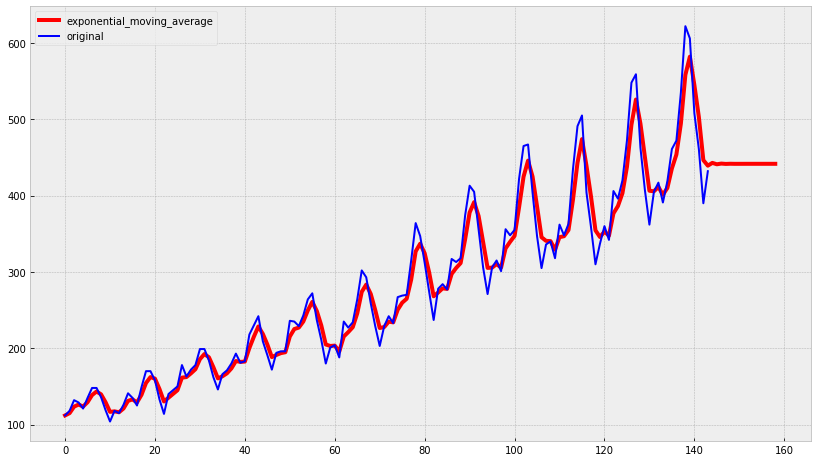

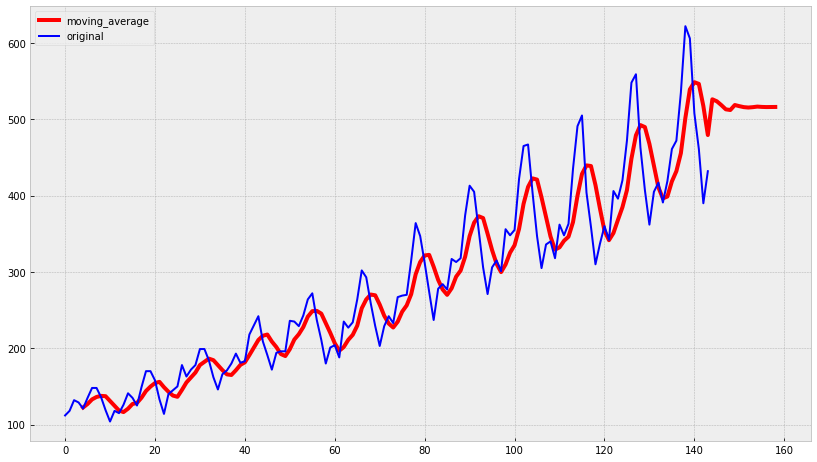

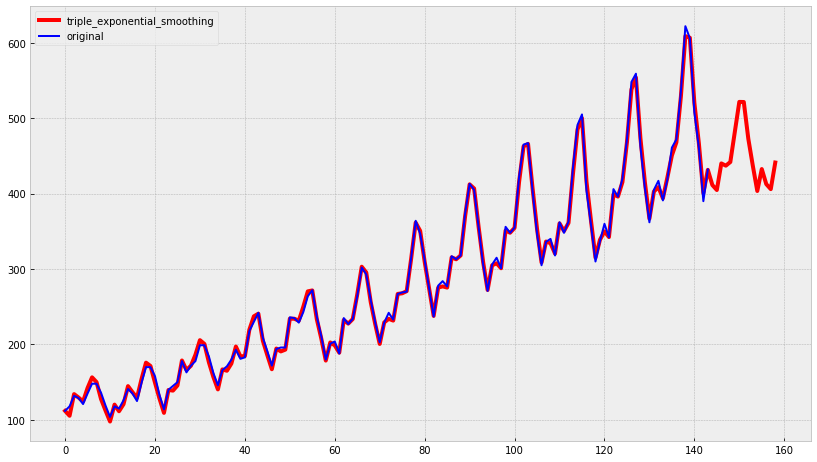

In [157]:
# Как видно triple_exponential_smoothing
# показывает лучшие результаты

Opt_param(exponential_moving_average,series,[0,0,0], ((0, 0.5), (0, 1), (0, 1)),15)
Opt_param(moving_average, series, [0,0,0], ((5, 10), (0, 1), (0, 1)), 15)
Opt_param(triple_exponential_smoothing,series,[0,0,0], ((0.5, 1), (0, 1), (0, 1)), 15)

